## Loan Eligibility Project - Part 1

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from fancyimpute import KNN,SoftImpute
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib
from df_summary import df_summary
import copy
from sklearn.impute import IterativeImputer

In [5]:
os.getcwd()

'C:\\Users\\jbhsm\\Project_Pro\\Loan Eligibility Prediction\\loan_eligibility_proj\\lib'

In [421]:
input_dir=r'C:\\Users\\jbhsm\\Project_Pro\\Loan Eligibility Prediction\\loan_eligibility_proj\\input'

In [422]:
os.listdir(input_dir)

['LoansTrainingSetV2.csv', 'test_data.csv']

In [7]:
train_data_path = r'C:\\Users\\jbhsm\\Project_Pro\\Loan Eligibility Prediction\\loan_eligibility_proj\\input\\LoansTrainingSetV2.csv'
test_data_path= r'C:\\Users\\jbhsm\\Project_Pro\\Loan Eligibility Prediction\\loan_eligibility_proj\\input\\test_data.csv'

In [8]:
# Reading the dataframe
data=pd.read_csv(train_data_path,low_memory=False) 

In [10]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [20]:
data.shape

(111107, 19)

In [11]:
# Changing column names - raplciong the space with _ for ease of work

def  col_name_mod(columns):
    '''
    columns - list of columns names in the data frame
    
    Returns:
    new_col_name - list of columns names are returned will all the blanks replaced with "_" and all name 
    converted to lower case 
    
    '''
    new_col_name=[col.replace(" ","_").lower() for col in columns]
    
    return new_col_name


In [12]:
# Replacing the columns name having blanks with "_" 
mod_col_name=col_name_mod(data.columns)

In [14]:
print(mod_col_name)

['loan_id', 'customer_id', 'loan_status', 'current_loan_amount', 'term', 'credit_score', 'years_in_current_job', 'home_ownership', 'annual_income', 'purpose', 'monthly_debt', 'years_of_credit_history', 'months_since_last_delinquent', 'number_of_open_accounts', 'number_of_credit_problems', 'current_credit_balance', 'maximum_open_credit', 'bankruptcies', 'tax_liens']


In [15]:
data.columns = mod_col_name

In [17]:
summary=df_summary(data,'loan_status')

In [21]:
summary.get_isimbalanced()

This is  Imbalanced dataset 

          index    dist
0    Loan Given  77.343
1  Loan Refused  22.657


In [18]:
summary.get_summary()

,Null,dtype,unique,pct_Null,Loan Given_p_NL,Loan Refused_p_NL
index,,,,,,
loan_id,0,object,88910,0.0%,0 - 0.0%,0 - 0.0%
customer_id,0,object,88910,0.0%,0 - 0.0%,0 - 0.0%
loan_status,0,object,2,0.0%,0 - 0.0%,0 - 0.0%
current_loan_amount,0,int64,22541,0.0%,0 - 0.0%,0 - 0.0%
term,0,object,2,0.0%,0 - 0.0%,0 - 0.0%
credit_score,21338,float64,326,19.2%,15294 - 17.8%,6044 - 24.0%
years_in_current_job,4693,object,11,4.22%,3285 - 3.8%,1408 - 5.6%
home_ownership,0,object,4,0.0%,0 - 0.0%,0 - 0.0%
annual_income,21338,float64,37983,19.2%,15294 - 17.8%,6044 - 24.0%


**Thoughts**

* Six features have Null values.
* The feature months_since_last_delinquent - has 53.1% values as Null, Its contribution is significant in both the target classes.
* No of Null values in bankruptcies and tax_liens is vbery low and its contribution to target class (Loan refused) is only 0.2 and 0%
* for credit score and annual income - no of Null present is same and its distribution in major and minor class is similar 
* No.of unique values in loan_id is 88910 with out Nulls, but the shape of the data frame is 111107, this may be due to duplicate values, which need to be removed.
* Categorical variable need to be addressed.
* This an imbalanced data set - which need to be adequately treated


## Exploratory Data Analysis

### Univariate Analysis

In [38]:
def plot_hist_boxplot(df, column):
    
    import seaborn as sns
    from scipy.stats import kurtosis,skew 
    '''
    This method to be used for features which are continuous in nature. (Ex. float, int)
    df - dataframe
    columns = str - name of the columns that need to be described  
    
    prints:
    A distribution plot and a box plot will be printed.
    Skewness and the kutosis will also be printed
    
    '''
    
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.distplot(df[df[column].notnull()][column],ax=ax1)
    sns.boxplot(y=df[df[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(df[df[column].notnull()][column]))
    print("kurtosis : ",kurtosis(df[df[column].notnull()][column]))
    plt.show()

In [39]:
def plot_count_boxplot(df,column):
   
    import seaborn as sns
    from scipy.stats import kurtosis,skew 

    '''
    This method to be used for features which are categorical in nature. (Ex. object)
    df - dataframe
    columns = str - name of the columns that need to be described  
    
    prints:
    A count plot and a box plot will be printed.
    Skewness and the kutosis will also be printed
    '''
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,6))
    sns.countplot(df[df[column].notnull()][column],ax=ax1)
    sns.boxplot(y=df[df[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(df[df[column].notnull()][column]))
    print("kurtosis : ",kurtosis(df[df[column].notnull()][column]))
    plt.show()

In [33]:
col_name_cat=[col  for col in data.columns if data[col].dtype=='O']
col_name_num=data.columns.difference(col_name_cat)

In [34]:
print(col_name_cat)

['loan_id', 'customer_id', 'loan_status', 'term', 'years_in_current_job', 'home_ownership', 'purpose', 'monthly_debt', 'maximum_open_credit']


In [35]:
print(col_name_num)

Index(['annual_income', 'bankruptcies', 'credit_score',
       'current_credit_balance', 'current_loan_amount',
       'months_since_last_delinquent', 'number_of_credit_problems',
       'number_of_open_accounts', 'tax_liens', 'years_of_credit_history'],
      dtype='object')


#### Univariate - Numeric

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  44.74598747836201
kurtosis :  6398.3206670975605


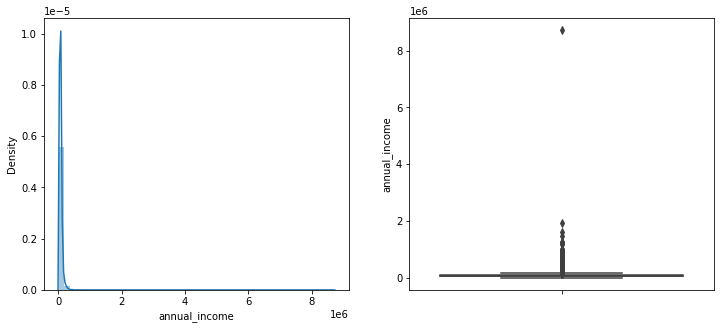

In [40]:
plot_hist_boxplot(data,'annual_income')

In [42]:
data["annual_income"].describe()

count    8.976900e+04
mean     7.248600e+04
std      5.593094e+04
min      4.033000e+03
25%      4.468800e+04
50%      6.175200e+04
75%      8.688700e+04
max      8.713547e+06
Name: annual_income, dtype: float64

In [109]:
data['annual_income'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200     40856.0
0.750     86887.0
0.900    120172.8
0.950    147795.0
0.990    241416.0
0.999    492143.6
Name: annual_income, dtype: float64

**Thoughts**

* kurtosis is signifcantly high, which shows presence of outliers -> 6398, which is >>> 3
* This is evident from the above desription, max values is 8.71 e+06, where at 75% the value is 8.68 e+04
* we note that from 90% quantile value, there is a sudden jump in the figure, again there is sudden jump observed between 99% quantile and 99.9% quantile.

In [111]:
# Capping any values greater than 99% to 99th value
data.loc[data['annual_income'] > 241416, 'annual_income'] = 241416

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  1.709952616197671
kurtosis :  3.964910083504873


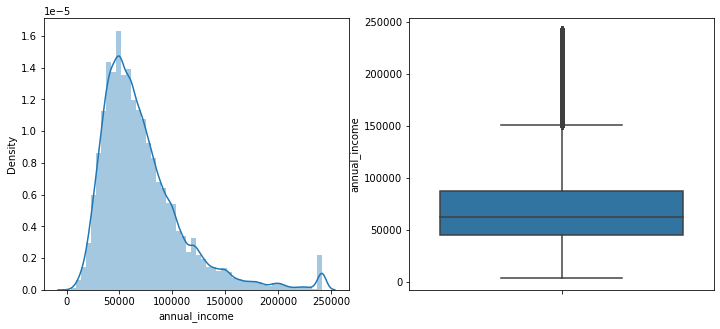

In [112]:
plot_hist_boxplot(data,'annual_income')

**Thoughts**

* The distribution has significantly improved, as the kurtosis is closer to 3, which signifies a normal distribution.
* The data remains positively skewed.
* to be noted here that, this feature contains Null values which also need to be treated.

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  3.494620818066707
kurtosis :  18.196138116147882


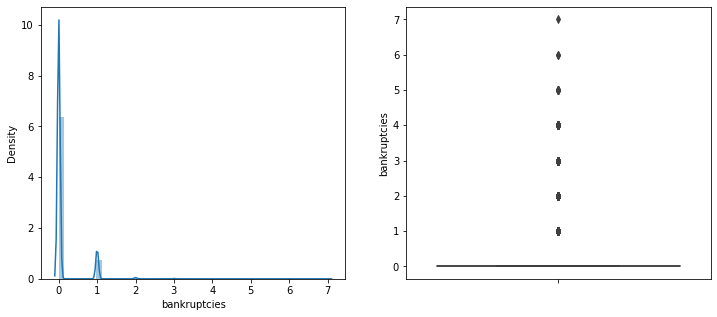

In [113]:
# Bankruptcies
plot_hist_boxplot(data,'bankruptcies')

In [114]:
data["bankruptcies"].describe()

count    110879.00000
mean          0.11766
std           0.35142
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max           7.00000
Name: bankruptcies, dtype: float64

In [115]:
data['bankruptcies'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200    0.0
0.750    0.0
0.900    1.0
0.950    1.0
0.990    1.0
0.999    3.0
Name: bankruptcies, dtype: float64

In [117]:
data['bankruptcies'].quantile([.2,0.75,0.90,.95,0.99,.999,.9999,1])

0.2000    0.0
0.7500    0.0
0.9000    1.0
0.9500    1.0
0.9900    1.0
0.9990    3.0
0.9999    4.0
1.0000    7.0
Name: bankruptcies, dtype: float64

In [120]:
# We can see that maximum of the values are 0 and 1 followed by 2 and 3
data['bankruptcies'].value_counts()

0.0    98650
1.0    11613
2.0      468
3.0      110
4.0       27
5.0        8
6.0        2
7.0        1
Name: bankruptcies, dtype: int64

In [121]:
#This feature has Null values 
data['bankruptcies'].isnull().sum()

228

**Thoughts**

* bankruptcies - there are 228 null values, which may be imputed considering if it is correlated with other features or not etc or else using iterative/soft imputer
* value of 7 may not be considered outlier, since 5 & 6 are also present, which gievs idea that 7 may be valid data

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  3.8673409659760876
kurtosis :  13.003289885613228


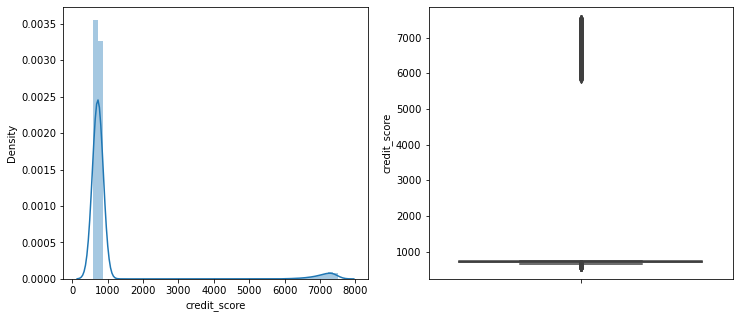

In [122]:
# Credit Score
plot_hist_boxplot(data,'credit_score')

In [124]:
data["credit_score"].describe()

count    89769.000000
mean      1075.795029
std       1474.133505
min        585.000000
25%        705.000000
50%        724.000000
75%        741.000000
max       7510.000000
Name: credit_score, dtype: float64

In [125]:
data['credit_score'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200     699.0
0.750     741.0
0.900     748.0
0.950    6690.0
0.990    7380.0
0.999    7480.0
Name: credit_score, dtype: float64

In [134]:
data['credit_score'].quantile([.94,.945,.95,.96,.97,0.99,.999,.9999])

0.9400     751.0
0.9450    6270.0
0.9500    6690.0
0.9600    7000.0
0.9700    7160.0
0.9900    7380.0
0.9990    7480.0
0.9999    7510.0
Name: credit_score, dtype: float64

* We can see, a portion of value ranges from 5500 to 7500 approximately, rest values are less than 1000
* The upper quartile is hooked at 748, where as max value is 7510, same is confirmed from the quantile data.
* We can see that,751 at 94 percentile jumps to 6270 at 94.5 percentile, more over credit score cannot be mmore than 800

In [135]:
# Imputation
data["credit_score"]=np.where(data["credit_score"]>800, data["credit_score"]/10, data["credit_score"])

In [138]:
# Using the mean to fill the Null
data["credit_score"].fillna(data["credit_score"].mean(),inplace=True)

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  -1.4882453491799483
kurtosis :  3.2045068363441986


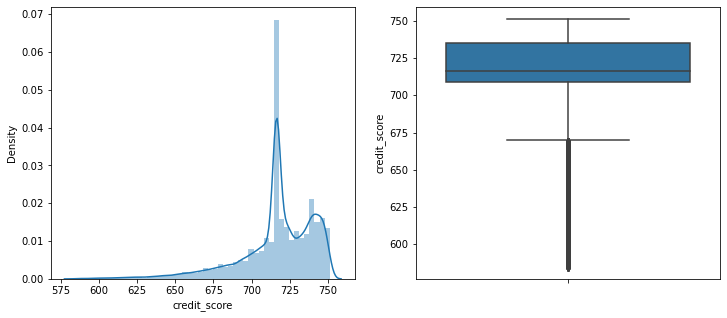

In [139]:
# credit_score
plot_hist_boxplot(data,'credit_score')

**Thoughts**

* The data is negetively skewed
* peak is observed at 716-720, due to NA values that were filled.
* the data need to be transformed.

In [211]:
def sqrt_trf(value_list):
   

    import numpy as np
    '''
    Input
    value-list = list or series of values int or float
    
    returns
    list of square transformed values   
    
    '''
    return np.sqrt(value_list) 

In [210]:
def log_trf(value_list):
    
    import numpy as np
    '''
    Input
    value-list = list or series of values int or float
    
    returns
    if the list doesnot contain values < 1, return np.log transformation of the values,
    else returns np.log1p transformation of the values
    '''
    
    if np.floor(value_list).any()==0:
        return np.log1p(value_list)
    else:
        return np.log(value_list)
    

In [205]:
def boxcox_trf(value_list):
   

    from scipy.stats import boxcox
    '''
    Input
    value-list = list or series of values int or float
    
    returns
    list of boxcox transformed values   
    
    '''
    epsilon = 0.0001
    value_list_updated = [val+epsilon for val in value_list if val==0]
    bcox_trf,_ =boxcox(value_list_updated)
    
    return bcox_trf   

In [180]:
def transform_feat(df,feature_list):
    
    import pandas as pd
    import numpy as np
    
    
    trf_dict={}
    dict_final={}
    for col in feature_list:
        log_trf_data=pd.Series(log_trf(df[col]))
        bcox_trf_data=pd.Series(boxcox_trf(df[col]))
        sqrt_trf_data=pd.Series(np.sqrt(df[col]))
        trf_dict['skew_b4_trf']=np.round(df[col].skew(),3)
        trf_dict['log_trf']=np.round(log_trf_data.skew(),3)
        trf_dict['bcox_trf']=np.round(bcox_trf_data.skew(),3)
        trf_dict['sqrt_trf']=np.round(sqrt_trf_data.skew(),3)
        dict_final[col]=trf_dict
        trf_dict={}

    df_dict=pd.DataFrame(dict_final).transpose()
    
    return df_dict

In [181]:
trf_val=transform_feat(data,['credit_score'])

In [182]:
trf_val

,bcox_trf,log_trf,skew_b4_trf,sqrt_trf
credit_score,-0.088,-1.66,-1.488,-1.573


**Thoughts**

* Boxcox provides lowest skew values
* we shall do boxcox transformation on this feature

In [183]:
data["credit_score_trf"]=boxcox_trf(data["credit_score"])

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  -0.0876646336606379
kurtosis :  -0.46656133690885637


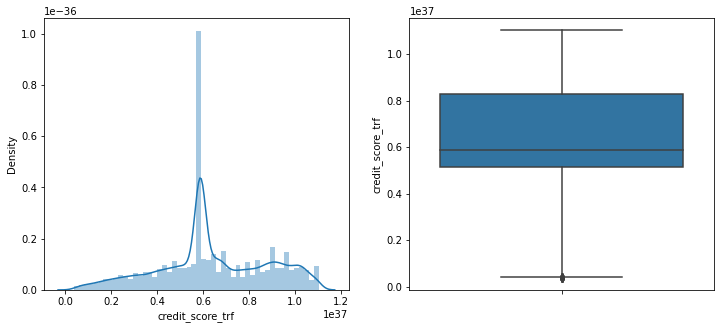

In [184]:
# credit_score
plot_hist_boxplot(data,'credit_score_trf')

In [396]:
data["credit_score_trf"].describe()

count    1.110960e+05
mean     6.400983e+36
std      2.374344e+36
min      4.002452e+35
25%      5.133306e+36
50%      5.879975e+36
75%      8.279105e+36
max      1.101817e+37
Name: credit_score_trf, dtype: float64

* Skewness has significantly improved and the distribution can be seen on both side of thecentral data

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  14.184075021155504
kurtosis :  671.5241083253418


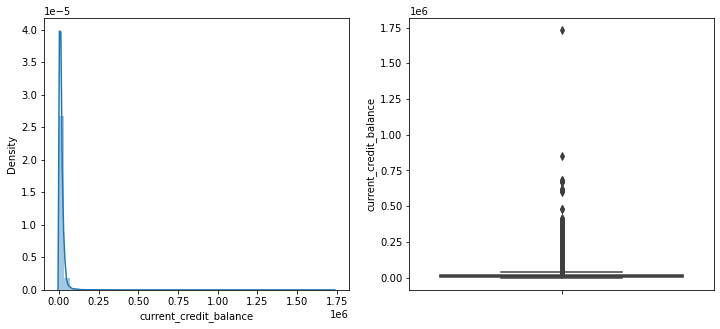

In [185]:
# current_credit_balance
plot_hist_boxplot(data,'current_credit_balance')

In [186]:
data["current_credit_balance"].describe()

count    1.111070e+05
mean     1.548314e+04
std      1.982115e+04
min      0.000000e+00
25%      5.905000e+03
50%      1.102700e+04
75%      1.933800e+04
max      1.730472e+06
Name: current_credit_balance, dtype: float64

In [187]:
data['current_credit_balance'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200      4994.0
0.750     19338.0
0.900     30979.0
0.950     40014.7
0.990     81594.2
0.999    229855.0
Name: current_credit_balance, dtype: float64

In [198]:
data['current_credit_balance'].quantile([0.99,0.992,.995,0.9992,.9999,1])

0.9900    8.159420e+04
0.9920    9.172882e+04
0.9950    1.116805e+05
0.9992    2.551000e+05
0.9999    4.735171e+05
1.0000    1.730472e+06
Name: current_credit_balance, dtype: float64

* The values above 99 percentile are replced with 99 percentile data

In [200]:
current_credit_balance_99_qtl_val=data['current_credit_balance'].quantile(0.99)
current_credit_balance_99_qtl_val

81594.20000000042

In [201]:
data.loc[data['current_credit_balance']>current_credit_balance_99_qtl_val,'current_credit_balance']=current_credit_balance_99_qtl_val

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  2.234046012800344
kurtosis :  6.70832866182495


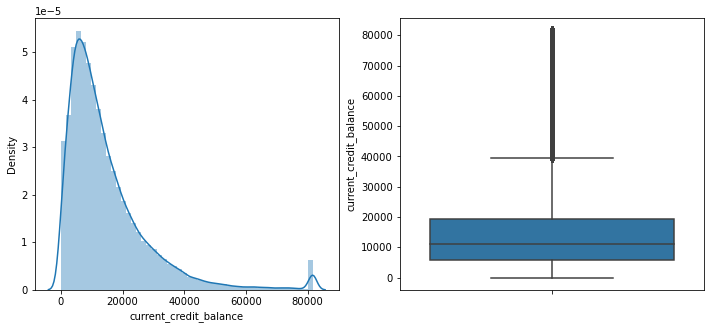

In [202]:
# current_credit_balance
plot_hist_boxplot(data,'current_credit_balance')

In [212]:
skew(sqrt_trf(data['current_credit_balance']))

0.7636907191034155

In [215]:
kurtosis(sqrt_trf(data['current_credit_balance']))

1.0633666538579236

In [216]:
data["current_credit_balance_trf"]=sqrt_trf(data['current_credit_balance'])

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  0.7636907191034155
kurtosis :  1.0633666538579236


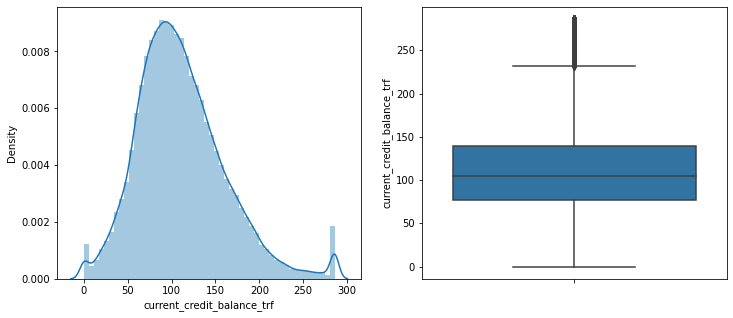

In [217]:
# current_credit_balance - sqrt transformed

plot_hist_boxplot(data,'current_credit_balance_trf')

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  2.4190854674456514
kurtosis :  3.8519751139356533


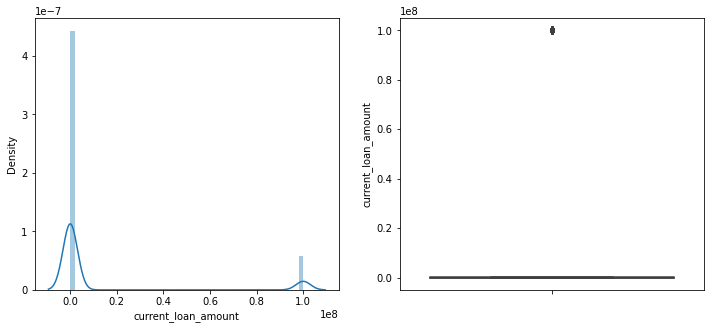

In [218]:
# current_loan_amount 

plot_hist_boxplot(data,'current_loan_amount')

In [219]:
data["current_loan_amount"].describe()

count    1.111070e+05
mean     1.147718e+07
std      3.185508e+07
min      4.910000e+02
25%      8.162000e+03
50%      1.418300e+04
75%      2.382200e+04
max      1.000000e+08
Name: current_loan_amount, dtype: float64

In [221]:
data['current_loan_amount'].quantile([.2,0.75,0.89,0.90,.95,0.99,.999])

0.200        7137.0
0.750       23822.0
0.890    99999999.0
0.900    99999999.0
0.950    99999999.0
0.990    99999999.0
0.999    99999999.0
Name: current_loan_amount, dtype: float64

* This shows that there is a wrong entry 90 percentile onwards

In [224]:
temp=np.array(data["current_loan_amount"].values.tolist())
data["current_loan_amount"] = np.where(temp > 9999998,np.nan,temp).tolist()

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  0.7618430127035156
kurtosis :  -0.11570849665708716


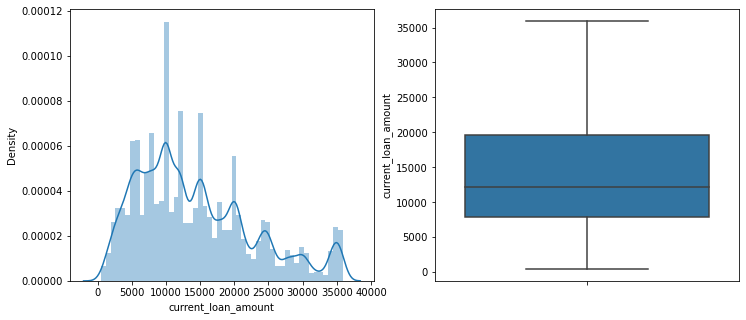

In [225]:
# current_loan_amount 

plot_hist_boxplot(data,'current_loan_amount')

In [223]:
current_loan_amount_median = data['current_loan_amount'].quantile(0.5)
current_loan_amount_median

14183.0

In [228]:
# Replacing the error value with the median value
data["current_loan_amount"].fillna(current_loan_amount_median, inplace=True) 

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  0.8096276550915971
kurtosis :  0.2577404673099233


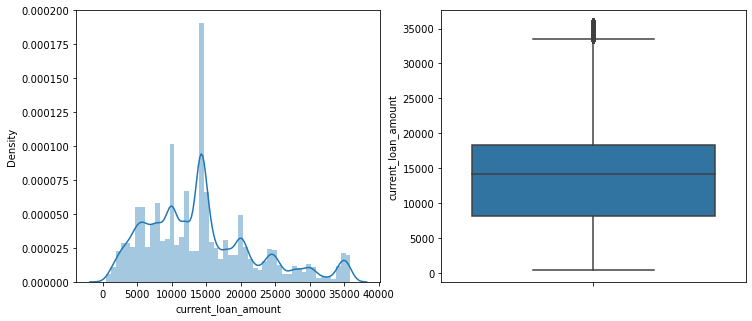

In [229]:
# current_loan_amount 

plot_hist_boxplot(data,'current_loan_amount')

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  0.4354627891485026
kurtosis :  -0.7484343414753551


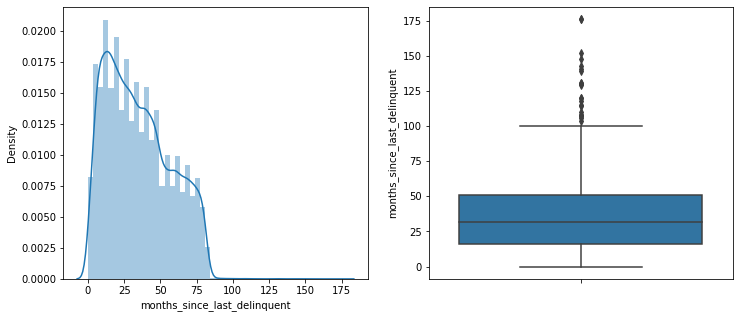

In [230]:
# months_since_last_delinquent 

plot_hist_boxplot(data,'months_since_last_delinquent')

In [231]:
data["months_since_last_delinquent"].describe()

count    52104.000000
mean        34.902272
std         21.970696
min          0.000000
25%         16.000000
50%         32.000000
75%         51.000000
max        176.000000
Name: months_since_last_delinquent, dtype: float64

In [232]:
data["months_since_last_delinquent"].quantile([.2,0.75,0.89,0.90,.95,0.99,.999])

0.200    14.0
0.750    51.0
0.890    67.0
0.900    68.0
0.950    75.0
0.990    81.0
0.999    85.0
Name: months_since_last_delinquent, dtype: float64

In [242]:
data["months_since_last_delinquent"].quantile([0.99,.9997,.9998,0.9999,1])

0.9900     81.0000
0.9997    111.4764
0.9998    125.2146
0.9999    140.5794
1.0000    176.0000
Name: months_since_last_delinquent, dtype: float64

In [237]:
data["months_since_last_delinquent"].nlargest(6)

83370     176.0
107595    176.0
552       152.0
27594     148.0
86795     143.0
15077     141.0
Name: months_since_last_delinquent, dtype: float64

* The values falling in last 1 percentile will be replaced by value at 99 percentile

In [244]:
months_since_last_delinquent_99_pctl = data["months_since_last_delinquent"].quantile(0.99)
months_since_last_delinquent_99_pctl

81.0

In [247]:
# Checking the target variable status 
# basically higher the value better it is, that means the customer have corrected himself/herself for last fail to pay
data[data["months_since_last_delinquent"]>160]["loan_status"].value_counts()

Loan Given    2
Name: loan_status, dtype: int64

* This feature also has null values, which we'll treat with imputer at the last

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  4.904699853856258
kurtosis :  49.28560237650115


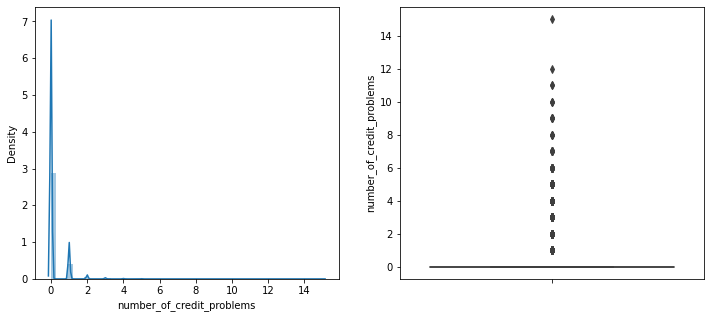

In [248]:
# number_of_credit_problems 

plot_hist_boxplot(data,'number_of_credit_problems')

In [249]:
data["number_of_credit_problems"].describe()

count    111107.000000
mean          0.168027
std           0.484212
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: number_of_credit_problems, dtype: float64

In [250]:
data["number_of_credit_problems"].quantile([.2,0.75,0.89,0.90,.95,0.99,.999])

0.200    0.0
0.750    0.0
0.890    1.0
0.900    1.0
0.950    1.0
0.990    2.0
0.999    4.0
Name: number_of_credit_problems, dtype: float64

In [251]:
data["number_of_credit_problems"].quantile([0.99,.999,0.9991,0.9992,0.9995,0.9999,1])

0.9900     2.0000
0.9990     4.0000
0.9991     5.0000
0.9992     5.0000
0.9995     5.0000
0.9999     8.8894
1.0000    15.0000
Name: number_of_credit_problems, dtype: float64

In [252]:
data["number_of_credit_problems"].nlargest(10)

44096    15
927      12
50478    11
95403    11
20008    10
48390    10
48996    10
10987     9
23221     9
74634     9
Name: number_of_credit_problems, dtype: int64

In [253]:
data["number_of_credit_problems"].value_counts()

0     95642
1     13366
2      1444
3       418
4       135
5        59
6        19
7         8
9         5
8         4
10        3
11        2
12        1
15        1
Name: number_of_credit_problems, dtype: int64

* Mximum values are located with 0 & 1, but 15 is not abrupt, 11 and 12 is also present.

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  1.1829930734599152
kurtosis :  3.041274693636143


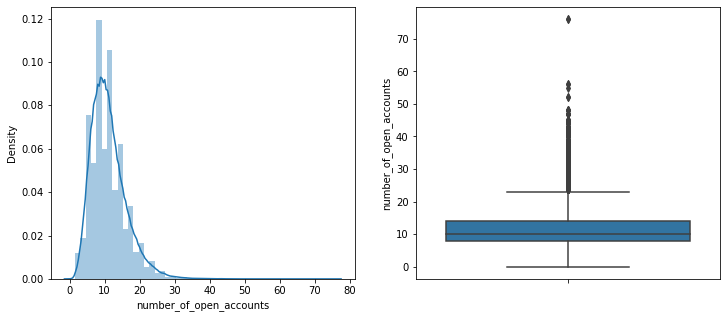

In [254]:
# number_of_open_accounts 

plot_hist_boxplot(data,'number_of_open_accounts')

In [256]:
data["number_of_open_accounts"].describe()

count    111107.000000
mean         11.125105
std           5.010267
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
max          76.000000
Name: number_of_open_accounts, dtype: float64

In [257]:
data["number_of_open_accounts"].quantile([.2,0.75,0.89,0.90,.95,0.99,.999])

0.200     7.0
0.750    14.0
0.890    17.0
0.900    18.0
0.950    20.0
0.990    27.0
0.999    36.0
Name: number_of_open_accounts, dtype: float64

In [258]:
data["number_of_open_accounts"].quantile([0.99,.999,0.9991,0.9992,0.9995,0.9999,1])

0.9900    27.0
0.9990    36.0
0.9991    37.0
0.9992    37.0
0.9995    40.0
0.9999    47.0
1.0000    76.0
Name: number_of_open_accounts, dtype: float64

In [260]:
data["number_of_open_accounts"].nlargest(10)

2251     76
54292    76
8600     56
91365    56
82187    55
62863    52
63805    52
50863    48
54937    48
92613    48
Name: number_of_open_accounts, dtype: int64

In [262]:
# Replacing the 99 percentile data for values obtained in the last 1 percentile
data.loc[data['number_of_open_accounts'] > 36, 'number_of_open_accounts'] = 36

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  1.0667541853691762
kurtosis :  1.8331000120510073


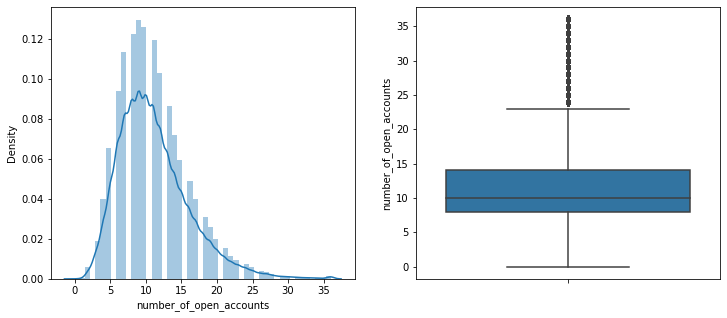

In [263]:
# number_of_open_accounts 

plot_hist_boxplot(data,'number_of_open_accounts')

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  15.632998232488033
kurtosis :  400.0699683076413


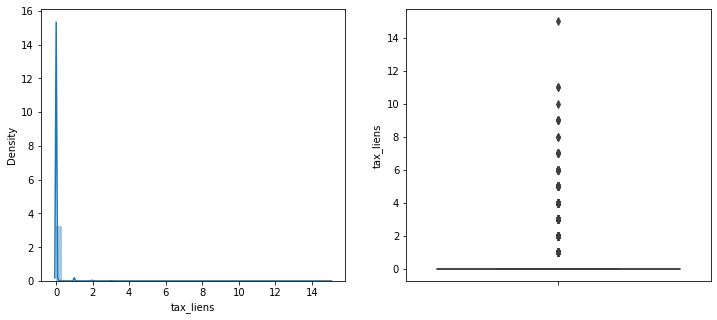

In [264]:
# tax_liens -  A tax lien is a legal claim against the assets of a person or business who fails to pay taxes owed

plot_hist_boxplot(data,'tax_liens')

In [265]:
data["tax_liens"].describe()

count    111096.000000
mean          0.029353
std           0.260575
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: tax_liens, dtype: float64

In [274]:
data["tax_liens"].quantile([0.99,0.997,.999,0.9992,0.9998,0.9999,1])

0.9900     1.0
0.9970     2.0
0.9990     4.0
0.9992     4.0
0.9998     6.0
0.9999     7.0
1.0000    15.0
Name: tax_liens, dtype: float64

In [269]:
data["tax_liens"].nlargest(15)

44096     15.0
50478     11.0
95403     11.0
48390     10.0
10987      9.0
20008      9.0
74634      9.0
86733      9.0
106862     9.0
23221      8.0
48996      8.0
927        7.0
9826       7.0
40476      7.0
56484      7.0
Name: tax_liens, dtype: float64

In [270]:
data["tax_liens"].value_counts()

0.0     108964
1.0       1485
2.0        408
3.0        124
4.0         66
5.0         19
6.0         12
7.0          7
9.0          5
8.0          2
11.0         2
15.0         1
10.0         1
Name: tax_liens, dtype: int64

In [280]:
data[data["tax_liens"]>11]["loan_status"].value_counts()

Loan Given    1
Name: loan_status, dtype: int64

In [282]:
data["tax_liens"].isnull().sum()

11

* entries where there are null values, does not fall in the minority class, hence these can be dropped

In [290]:
drop_idx_tax_lien = data[data["tax_liens"].isna()].index.to_list()

In [291]:
# Dropping the columns
data.drop(drop_idx_tax_lien, axis=0, inplace=True)

In [292]:
data.shape

(111096, 21)

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  1.0718126041960352
kurtosis :  1.746714984241569


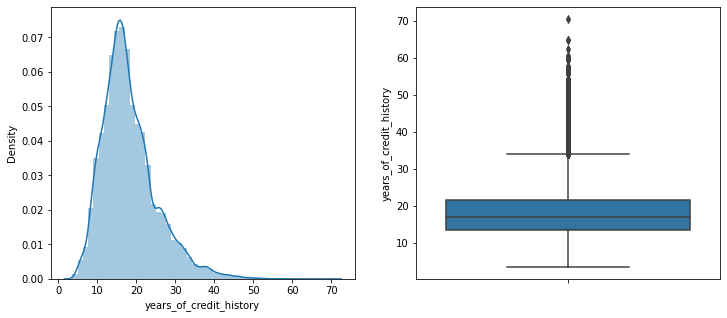

In [293]:
# years_of_credit_history

plot_hist_boxplot(data,'years_of_credit_history')

In [295]:
data["years_of_credit_history"].describe()

count    111096.000000
mean         18.200752
std           7.014595
min           3.600000
25%          13.500000
50%          16.900000
75%          21.700000
max          70.500000
Name: years_of_credit_history, dtype: float64

In [297]:
data["years_of_credit_history"].quantile([0.90,.95,0.99,.999,0.9995,0.9999,1])

0.9000    27.70000
0.9500    31.70000
0.9900    40.20000
0.9990    49.50000
0.9995    51.84525
0.9999    57.70000
1.0000    70.50000
Name: years_of_credit_history, dtype: float64

In [298]:
data["years_of_credit_history"].isnull().sum()

0

* Overall looks good, no null values

#### Univariate Categorical

In [308]:
data['term'].value_counts().reset_index()

,index,term
0,Short Term,80263
1,Long Term,30833


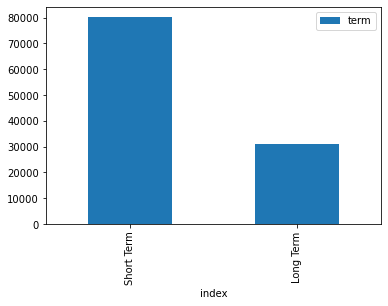

In [311]:
# Term
temp_df=data['term'].value_counts().reset_index().plot("index", "term",kind="bar")

In [312]:
# years_in_current_job

data["years_in_current_job"].head()

0     < 1 year
1    10+ years
2      9 years
3      3 years
4    10+ years
Name: years_in_current_job, dtype: object

In [313]:
data["years_in_current_job"].value_counts()

10+ years    34550
2 years      10158
3 years       9133
< 1 year      9051
5 years       7559
1 year        7173
4 years       6828
6 years       6310
7 years       6185
8 years       5104
9 years       4352
Name: years_in_current_job, dtype: int64

<AxesSubplot:xlabel='index'>

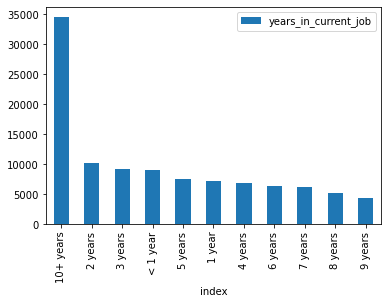

In [315]:
data["years_in_current_job"].value_counts().reset_index().plot("index","years_in_current_job",kind="bar")

In [316]:
# home_ownership

data["home_ownership"].head()

0             Rent
1    Home Mortgage
2    Home Mortgage
3             Rent
4    Home Mortgage
Name: home_ownership, dtype: object

In [317]:
data["home_ownership"].value_counts()

Home Mortgage    53814
Rent             46865
Own Home         10184
HaveMortgage       233
Name: home_ownership, dtype: int64

* The term "HaveMortgage" -is an typographical error and need to be corrected

In [318]:
data['home_ownership']=data['home_ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

In [319]:
data["home_ownership"].value_counts()

Home Mortgage    54047
Rent             46865
Own Home         10184
Name: home_ownership, dtype: int64

In [320]:
# purpose

data["purpose"].head()

0    Debt Consolidation
1    Debt Consolidation
2     Home Improvements
3    Debt Consolidation
4     Home Improvements
Name: purpose, dtype: object

In [321]:
data["purpose"].value_counts()

Debt Consolidation      87269
other                    6670
Home Improvements        6503
Other                    3595
Business Loan            1749
Buy a Car                1422
Medical Bills            1259
Buy House                 758
Take a Trip               622
major_purchase            407
small_business            318
moving                    167
wedding                   126
Educational Expenses      113
vacation                  107
renewable_energy           11
Name: purpose, dtype: int64

* the "Other" and "other" - onlly upper and lower case, actually refer to the same category - corrected.

In [322]:
data['purpose']=data['purpose'].str.replace('other', 'Other', regex=True)

In [323]:
data["purpose"].value_counts()

Debt Consolidation      87269
Other                   10265
Home Improvements        6503
Business Loan            1749
Buy a Car                1422
Medical Bills            1259
Buy House                 758
Take a Trip               622
major_purchase            407
small_business            318
moving                    167
wedding                   126
Educational Expenses      113
vacation                  107
renewable_energy           11
Name: purpose, dtype: int64

* The term "Other" have been updated, and we are good to go

In [324]:
# monthly_debt
data["monthly_debt"].head()

0     777.39
1     892.09
2    1244.02
3     990.94
4     503.71
Name: monthly_debt, dtype: object

In [325]:
data["monthly_debt"].value_counts()

0          81
837        10
807.53      9
679.32      9
775.08      9
           ..
1304.74     1
222.65      1
787.28      1
120.93      1
1468.22     1
Name: monthly_debt, Length: 70063, dtype: int64

In [327]:
#As we see there is a $ symbol present. Lets replace it 
data['monthly_debt']=data['monthly_debt'].str.replace('$', '', regex=True)

In [328]:
data['monthly_debt']=pd.to_numeric(data['monthly_debt'] )

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  2.2125321301988166
kurtosis :  21.343061918755943


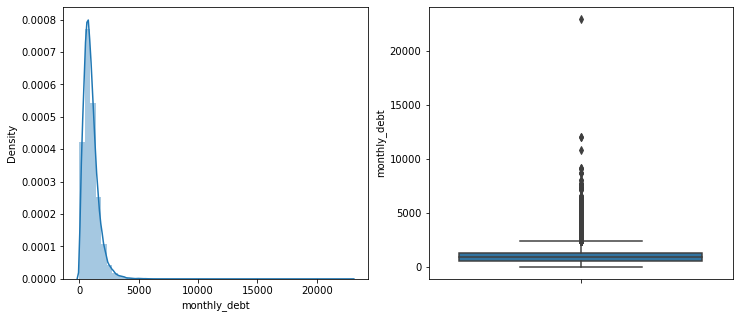

In [329]:
# monthly_debt 

plot_hist_boxplot(data,'monthly_debt')

In [330]:
data["monthly_debt"].describe()

count    111096.000000
mean        972.022887
std         641.640827
min           0.000000
25%         537.855000
50%         852.750000
75%        1262.747500
max       22939.120000
Name: monthly_debt, dtype: float64

In [331]:
data["monthly_debt"].quantile([.2,0.75,0.89,0.90,.95,0.99,.999])

0.200     468.71000
0.750    1262.74750
0.890    1704.54000
0.900    1759.13000
0.950    2131.03500
0.990    3094.05250
0.999    4963.84435
Name: monthly_debt, dtype: float64

In [334]:
data["monthly_debt"].quantile([0.90,.95,0.99,.999,.9999,.99995,0.99999,1])

0.90000     1759.130000
0.95000     2131.035000
0.99000     3094.052500
0.99900     4963.844350
0.99990     7987.620300
0.99995     9086.848148
0.99999    12055.680000
1.00000    22939.120000
Name: monthly_debt, dtype: float64

In [335]:
data["monthly_debt"].nlargest(15)

79754     22939.12
18582     12055.68
89942     12055.68
4012      10831.65
88606      9119.24
97849      9119.24
58593      9060.85
15551      8726.87
84620      8707.22
103042     8707.22
34891      8026.96
11248      8017.47
54841      7744.87
10752      7698.47
56966      7554.03
Name: monthly_debt, dtype: float64

In [336]:
#Replacing the values 99.9 percentile above with value of 99.9 percentile

monthly_debt_999_pctl=data[""].quantile(.999)
monthly_debt_999_pctl

4963.844350000004

In [337]:
data.loc[data['monthly_debt'] > monthly_debt_999_pctl, 'monthly_debt'] = monthly_debt_999_pctl

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  1.5559240863506538
kurtosis :  4.406725116147322


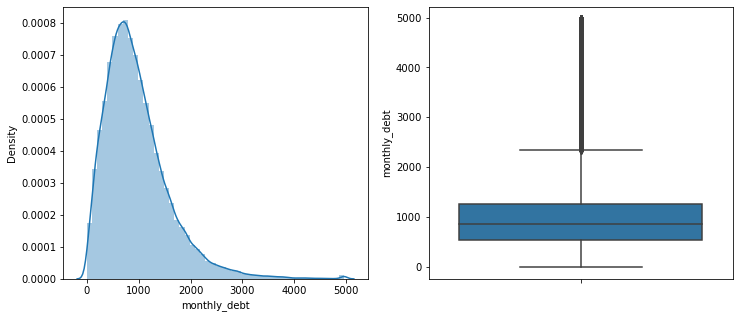

In [338]:
# monthly_debt 

plot_hist_boxplot(data,'monthly_debt')

In [341]:
skew(np.sqrt(data.monthly_debt))

0.3322352119379603

In [343]:
kurtosis(np.sqrt(data.monthly_debt))

0.5969755081708485

In [346]:
#Carrying out square root transformation
data["monthly_debt_trf"]=sqrt_trf(data.monthly_debt)

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  0.3322352119379603
kurtosis :  0.5969755081708485


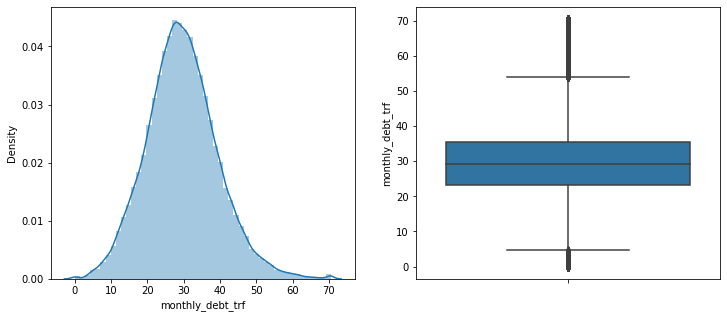

In [347]:
# monthly_debt 

plot_hist_boxplot(data,'monthly_debt_trf')

* Their are outliers, still the shape of the curve tend to normal distribution

In [351]:
# maximum_open_credit

data["maximum_open_credit"].head()

0     7946
1    77961
2    14815
3    43533
4    19553
Name: maximum_open_credit, dtype: object

In [354]:
#"#VALUE!" at position 4930 to be replaced with np.nan
data['maximum_open_credit']=data['maximum_open_credit'].replace('#VALUE!', np.nan, regex=True)

In [355]:
data['maximum_open_credit']=pd.to_numeric(data['maximum_open_credit'])

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  138.72464605952968
kurtosis :  22425.50242204931


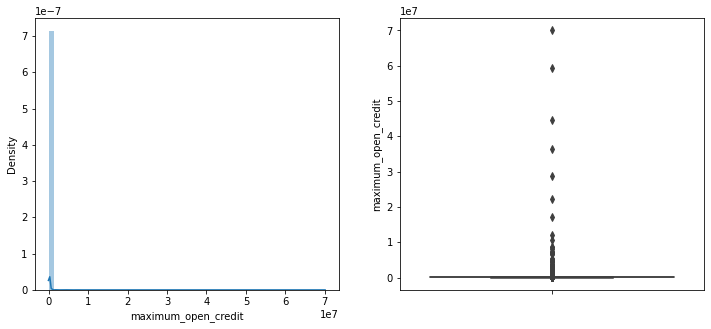

In [356]:
# monthly_debt 

plot_hist_boxplot(data,'maximum_open_credit')

In [357]:
data['maximum_open_credit'].describe()

count    1.110940e+05
mean     3.427546e+04
std      3.624997e+05
min      0.000000e+00
25%      1.241700e+04
50%      2.124250e+04
75%      3.558300e+04
max      6.998809e+07
Name: maximum_open_credit, dtype: float64

In [358]:
data["maximum_open_credit"].quantile([.2,0.75,0.89,0.90,.95,0.99,.999])

0.200     10782.000
0.750     35583.000
0.890     53237.770
0.900     55517.700
0.950     74528.700
0.990    164354.710
0.999    828520.907
Name: maximum_open_credit, dtype: float64

In [359]:
data["maximum_open_credit"].quantile([0.99,.999,0.9999,0.99999,1])

0.99000    1.643547e+05
0.99900    8.285209e+05
0.99990    7.892653e+06
0.99999    5.766992e+07
1.00000    6.998809e+07
Name: maximum_open_credit, dtype: float64

In [360]:
data["maximum_open_credit"].nlargest(10)

58916    69988086.0
18934    59305735.0
26426    44559330.0
74578    36284335.0
23155    28748988.0
79898    22242873.0
58529    17275104.0
45055    12068767.0
60994    10750537.0
42090     8740189.0
Name: maximum_open_credit, dtype: float64

In [361]:
data['maximum_open_credit'].isnull().sum()

2

In [362]:
data['maximum_open_credit'].quantile(0.75)

35583.0

In [363]:
data['maximum_open_credit'].fillna(data['maximum_open_credit'].quantile(0.75),inplace=True)

In [365]:
maximum_open_credit_99_pctl=data['maximum_open_credit'].quantile(0.99)
maximum_open_credit_99_pctl

164353.65000000014

In [367]:
data.loc[data['maximum_open_credit']>maximum_open_credit_99_pctl,"maximum_open_credit"]=maximum_open_credit_99_pctl

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  2.623856575882365
kurtosis :  9.304444174546783


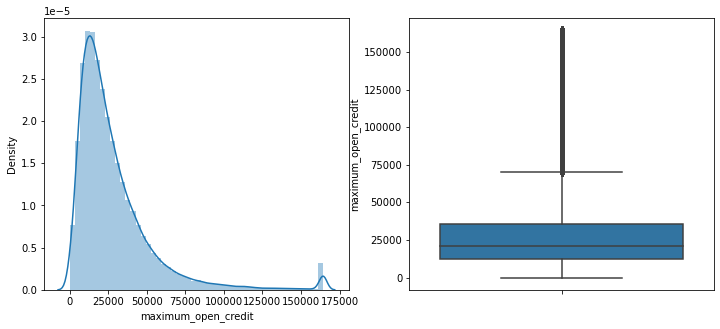

In [368]:
# monthly_debt 

plot_hist_boxplot(data,'maximum_open_credit')

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='maximum_open_credit', ylabel='Density'>

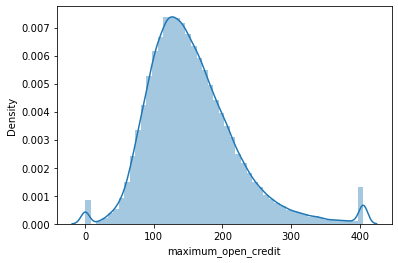

In [370]:
sns.distplot(np.sqrt(data['maximum_open_credit']))

In [371]:
# Carrying out squareroot transformation of the data
data['maximum_open_credit_trf']=np.sqrt(data['maximum_open_credit'])

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness :  1.0399005535529182
kurtosis :  2.048448048342226


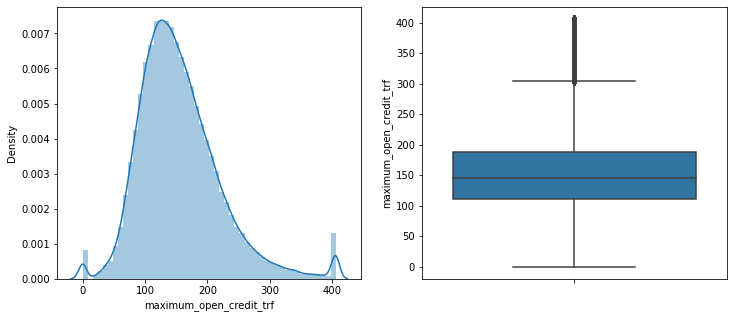

In [373]:
# monthly_debt 

plot_hist_boxplot(data,'maximum_open_credit_trf')

* Now the curve looks better

In [374]:
data.columns

Index(['loan_id', 'customer_id', 'loan_status', 'current_loan_amount', 'term',
       'credit_score', 'years_in_current_job', 'home_ownership',
       'annual_income', 'purpose', 'monthly_debt', 'years_of_credit_history',
       'months_since_last_delinquent', 'number_of_open_accounts',
       'number_of_credit_problems', 'current_credit_balance',
       'maximum_open_credit', 'bankruptcies', 'tax_liens', 'credit_score_trf',
       'current_credit_balance_trf', 'monthly_debt_trf',
       'maximum_open_credit_trf'],
      dtype='object')

In [377]:
columns_to_exclude=['loan_id', 'customer_id', 'credit_score',
       'current_credit_balance', 'monthly_debt',
       'maximum_open_credit']

In [378]:
updated_columns=data.columns.difference(columns_to_exclude)

In [379]:
df_wrk = copy.deepcopy(data[updated_columns])

In [380]:
# Updating numeric and categorical columns
col_name_cat=[col  for col in df_wrk.columns if data[col].dtype=='O']
col_name_num=df_wrk.columns.difference(col_name_cat)

In [381]:
col_name_cat

['home_ownership', 'loan_status', 'purpose', 'term', 'years_in_current_job']

In [382]:
col_name_num

Index(['annual_income', 'bankruptcies', 'credit_score_trf',
       'current_credit_balance_trf', 'current_loan_amount',
       'maximum_open_credit_trf', 'monthly_debt_trf',
       'months_since_last_delinquent', 'number_of_credit_problems',
       'number_of_open_accounts', 'tax_liens', 'years_of_credit_history'],
      dtype='object')

In [383]:
summary=df_summary(df_wrk,"loan_status")
summary.get_summary()

,Null,dtype,unique,pct_Null,Loan Given_p_NL,Loan Refused_p_NL
index,,,,,,
annual_income,21334,float64,37288,19.2%,15290 - 17.8%,6044 - 24.0%
bankruptcies,217,float64,8,0.2%,163 - 0.2%,54 - 0.2%
credit_score_trf,0,float64,168,0.0%,0 - 0.0%,0 - 0.0%
current_credit_balance_trf,0,float64,32845,0.0%,0 - 0.0%,0 - 0.0%
current_loan_amount,0,float64,22539,0.0%,0 - 0.0%,0 - 0.0%
home_ownership,0,object,3,0.0%,0 - 0.0%,0 - 0.0%
loan_status,0,object,2,0.0%,0 - 0.0%,0 - 0.0%
maximum_open_credit_trf,0,float64,45682,0.0%,0 - 0.0%,0 - 0.0%
monthly_debt_trf,0,float64,69977,0.0%,0 - 0.0%,0 - 0.0%


In [384]:
# Factorizing the categorical data
for c in col_name_cat:
    df_wrk[c] = pd.factorize(df_wrk[c])[0]


In [389]:

df_wrk[col_name_cat].head()

,home_ownership,loan_status,purpose,term,years_in_current_job
0,0,0,0,0,0
1,1,0,0,1,1
2,1,0,1,0,2
3,0,0,0,0,3
4,1,0,1,1,1


In [387]:
df_wrk['home_ownership'].value_counts()

1    54047
0    46865
2    10184
Name: home_ownership, dtype: int64

In [390]:
summary=df_summary(df_wrk,"loan_status")
summary.get_summary()

,Null,dtype,unique,pct_Null,1_p_NL,0_p_NL
index,,,,,,
annual_income,21334,float64,37288,19.2%,15290 - 17.8%,6044 - 24.0%
bankruptcies,217,float64,8,0.2%,163 - 0.2%,54 - 0.2%
credit_score_trf,0,float64,168,0.0%,0 - 0.0%,0 - 0.0%
current_credit_balance_trf,0,float64,32845,0.0%,0 - 0.0%,0 - 0.0%
current_loan_amount,0,float64,22539,0.0%,0 - 0.0%,0 - 0.0%
home_ownership,0,int64,3,0.0%,0 - 0.0%,0 - 0.0%
loan_status,0,object,2,0.0%,0 - 0.0%,0 - 0.0%
maximum_open_credit_trf,0,float64,45682,0.0%,0 - 0.0%,0 - 0.0%
monthly_debt_trf,0,float64,69977,0.0%,0 - 0.0%,0 - 0.0%


**Thoughts**
* All the features have ben converted to numeric features.
* We have to get the dummies of all these features and add this on to the main dataframe
* This will be followed by soft imputing.

In [392]:
df_wrk.head()

,annual_income,bankruptcies,credit_score_trf,current_credit_balance_trf,current_loan_amount,home_ownership,loan_status,maximum_open_credit_trf,monthly_debt_trf,months_since_last_delinquent,number_of_credit_problems,number_of_open_accounts,purpose,tax_liens,term,years_in_current_job,years_of_credit_history
0,46643.0,0.0,7.291656e+36,82.231381,12232.0,0,0,89.140339,27.881714,10.0,0,12,0,0.0,0,0,18.0
1,81099.0,0.0,7.985056e+36,188.960313,25014.0,1,0,279.214971,29.867876,NaN,0,14,0,0.0,1,1,26.7
2,60438.0,1.0,6.777494e+36,106.183803,16117.0,1,0,121.716885,35.270668,32.0,1,11,1,0.0,0,2,16.7
3,34171.0,0.0,9.058593e+36,83.719771,11716.0,0,0,208.645633,31.479199,NaN,0,21,0,0.0,0,3,10.0
4,47003.0,1.0,3.313723e+36,130.049990,9789.0,1,0,139.832042,22.443485,25.0,1,13,1,0.0,1,1,16.7


In [395]:
summary=df_summary(df_wrk,"loan_status")
summary.get_summary()

,Null,dtype,unique,pct_Null,1_p_NL,0_p_NL
index,,,,,,
annual_income,21334,float64,37288,19.2%,15290 - 17.8%,6044 - 24.0%
bankruptcies,217,float64,8,0.2%,163 - 0.2%,54 - 0.2%
credit_score_trf,0,float64,168,0.0%,0 - 0.0%,0 - 0.0%
current_credit_balance_trf,0,float64,32845,0.0%,0 - 0.0%,0 - 0.0%
current_loan_amount,0,float64,22539,0.0%,0 - 0.0%,0 - 0.0%
home_ownership,0,int64,3,0.0%,0 - 0.0%,0 - 0.0%
loan_status,0,object,2,0.0%,0 - 0.0%,0 - 0.0%
maximum_open_credit_trf,0,float64,45682,0.0%,0 - 0.0%,0 - 0.0%
monthly_debt_trf,0,float64,69977,0.0%,0 - 0.0%,0 - 0.0%


In [397]:
# Only df_wrk is being scaled - due very high value e^37, this impacty the imputing algorithim, and stopped it from fuunctioning
df_wrk["credit_score_trf"]=preprocessing.scale(df_wrk["credit_score_trf"])

c:\users\jbhsm\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [398]:
df_wrk["credit_score_trf"].describe()

count    1.110960e+05
mean    -4.502611e-17
std      1.000005e+00
min     -2.527336e+00
25%     -5.339089e-01
50%     -2.194337e-01
75%      7.910102e-01
max      1.944626e+00
Name: credit_score_trf, dtype: float64

In [399]:
df_wrk.head()

,annual_income,bankruptcies,credit_score_trf,current_credit_balance_trf,current_loan_amount,home_ownership,loan_status,maximum_open_credit_trf,monthly_debt_trf,months_since_last_delinquent,number_of_credit_problems,number_of_open_accounts,purpose,tax_liens,term,years_in_current_job,years_of_credit_history
0,46643.0,0.0,0.375125,82.231381,12232.0,0,0,89.140339,27.881714,10.0,0,12,0,0.0,0,0,18.0
1,81099.0,0.0,0.667165,188.960313,25014.0,1,0,279.214971,29.867876,NaN,0,14,0,0.0,1,1,26.7
2,60438.0,1.0,0.158575,106.183803,16117.0,1,0,121.716885,35.270668,32.0,1,11,1,0.0,0,2,16.7
3,34171.0,0.0,1.119308,83.719771,11716.0,0,0,208.645633,31.479199,NaN,0,21,0,0.0,0,3,10.0
4,47003.0,1.0,-1.300264,130.049990,9789.0,1,0,139.832042,22.443485,25.0,1,13,1,0.0,1,1,16.7


In [400]:
#Imputing missing data with soft impute
updated_data_sft_impt=pd.DataFrame(data=SoftImpute().fit_transform(df_wrk.drop("loan_status",axis=1)), columns=df_wrk.drop("loan_status",axis=1).columns, index=df_wrk.index)

[SoftImpute] Max Singular Value of X_init = 24785657.485198
[SoftImpute] Iter 1: observed MAE=157.306681 rank=2
[SoftImpute] Iter 2: observed MAE=157.270140 rank=2
[SoftImpute] Iter 3: observed MAE=157.283472 rank=2
[SoftImpute] Iter 4: observed MAE=157.309000 rank=2
[SoftImpute] Iter 5: observed MAE=157.337050 rank=2
[SoftImpute] Iter 6: observed MAE=157.365212 rank=2
[SoftImpute] Iter 7: observed MAE=157.392843 rank=2
[SoftImpute] Iter 8: observed MAE=157.419765 rank=2
[SoftImpute] Iter 9: observed MAE=157.445908 rank=2
[SoftImpute] Iter 10: observed MAE=157.471260 rank=2
[SoftImpute] Iter 11: observed MAE=157.495817 rank=2
[SoftImpute] Iter 12: observed MAE=157.519600 rank=2
[SoftImpute] Iter 13: observed MAE=157.542773 rank=2
[SoftImpute] Iter 14: observed MAE=157.565409 rank=2
[SoftImpute] Iter 15: observed MAE=157.587354 rank=2
[SoftImpute] Iter 16: observed MAE=157.608624 rank=2
[SoftImpute] Iter 17: observed MAE=157.629245 rank=2
[SoftImpute] Iter 18: observed MAE=157.649332 ra

In [401]:
updated_data_sft_impt.head()

,annual_income,bankruptcies,credit_score_trf,current_credit_balance_trf,current_loan_amount,home_ownership,maximum_open_credit_trf,monthly_debt_trf,months_since_last_delinquent,number_of_credit_problems,number_of_open_accounts,purpose,tax_liens,term,years_in_current_job,years_of_credit_history
0,46643.0,0.0,0.375125,82.231381,12232.0,0.0,89.140339,27.881714,10.000000,0.0,12.0,0.0,0.0,0.0,0.0,18.0
1,81099.0,0.0,0.667165,188.960313,25014.0,1.0,279.214971,29.867876,39.024730,0.0,14.0,0.0,0.0,1.0,1.0,26.7
2,60438.0,1.0,0.158575,106.183803,16117.0,1.0,121.716885,35.270668,32.000000,1.0,11.0,1.0,0.0,0.0,2.0,16.7
3,34171.0,0.0,1.119308,83.719771,11716.0,0.0,208.645633,31.479199,17.575415,0.0,21.0,0.0,0.0,0.0,3.0,10.0
4,47003.0,1.0,-1.300264,130.049990,9789.0,1.0,139.832042,22.443485,25.000000,1.0,13.0,1.0,0.0,1.0,1.0,16.7


In [402]:
data_concat=pd.concat([updated_data_sft_impt,df_wrk.loan_status], axis=1)

In [403]:
data_concat.head()

,annual_income,bankruptcies,credit_score_trf,current_credit_balance_trf,current_loan_amount,home_ownership,maximum_open_credit_trf,monthly_debt_trf,months_since_last_delinquent,number_of_credit_problems,number_of_open_accounts,purpose,tax_liens,term,years_in_current_job,years_of_credit_history,loan_status
0,46643.0,0.0,0.375125,82.231381,12232.0,0.0,89.140339,27.881714,10.000000,0.0,12.0,0.0,0.0,0.0,0.0,18.0,0
1,81099.0,0.0,0.667165,188.960313,25014.0,1.0,279.214971,29.867876,39.024730,0.0,14.0,0.0,0.0,1.0,1.0,26.7,0
2,60438.0,1.0,0.158575,106.183803,16117.0,1.0,121.716885,35.270668,32.000000,1.0,11.0,1.0,0.0,0.0,2.0,16.7,0
3,34171.0,0.0,1.119308,83.719771,11716.0,0.0,208.645633,31.479199,17.575415,0.0,21.0,0.0,0.0,0.0,3.0,10.0,0
4,47003.0,1.0,-1.300264,130.049990,9789.0,1.0,139.832042,22.443485,25.000000,1.0,13.0,1.0,0.0,1.0,1.0,16.7,0


In [404]:
summary=df_summary(data_concat,"loan_status")
summary.get_summary()

,Null,dtype,unique,pct_Null,1_p_NL,0_p_NL
index,,,,,,
annual_income,0,float64,58622,0.0%,0 - 0.0%,0 - 0.0%
bankruptcies,0,float64,208,0.0%,0 - 0.0%,0 - 0.0%
credit_score_trf,0,float64,168,0.0%,0 - 0.0%,0 - 0.0%
current_credit_balance_trf,0,float64,32845,0.0%,0 - 0.0%,0 - 0.0%
current_loan_amount,0,float64,22539,0.0%,0 - 0.0%,0 - 0.0%
home_ownership,0,float64,3,0.0%,0 - 0.0%,0 - 0.0%
maximum_open_credit_trf,0,float64,45682,0.0%,0 - 0.0%,0 - 0.0%
monthly_debt_trf,0,float64,69977,0.0%,0 - 0.0%,0 - 0.0%
months_since_last_delinquent,0,float64,53219,0.0%,0 - 0.0%,0 - 0.0%


* No Null Values

In [412]:
ann_inc_na_lst=df_wrk[df_wrk.annual_income.isna()].index.to_list()
bankrupt_na_lst=df_wrk[df_wrk.bankruptcies.isna()].index.to_list()
months_since_last_delinquent_na_lst=df_wrk[df_wrk.months_since_last_delinquent.isna()].index.to_list()

In [414]:
data_concat.loc[ann_inc_na_lst].annual_income.values

array([31002.54973419, 22020.95308702, 33252.50846354, ...,
        9238.75550651,  7840.2944262 ,  9244.85693439])

In [415]:
updated_data_sft_impt.loc[ann_inc_na_lst].annual_income.values

array([31002.54973419, 22020.95308702, 33252.50846354, ...,
        9238.75550651,  7840.2944262 ,  9244.85693439])

In [410]:
#Imputing missing data with soft impute
updated_data_iter_impt=pd.DataFrame(data=IterativeImputer(random_state=0).fit_transform(df_wrk.drop("loan_status",axis=1)), columns=df_wrk.drop("loan_status",axis=1).columns, index=df_wrk.index)

In [411]:
updated_data_iter_impt.isnull().sum()

annual_income                   0
bankruptcies                    0
credit_score_trf                0
current_credit_balance_trf      0
current_loan_amount             0
home_ownership                  0
maximum_open_credit_trf         0
monthly_debt_trf                0
months_since_last_delinquent    0
number_of_credit_problems       0
number_of_open_accounts         0
purpose                         0
tax_liens                       0
term                            0
years_in_current_job            0
years_of_credit_history         0
dtype: int64

In [416]:
ann_inc_dict={}
#Annual Income
ann_inc_dict["ann_inc_sft_imp"]=updated_data_sft_impt.loc[ann_inc_na_lst].annual_income.values
ann_inc_dict["ann_inc_iter_imp"]=updated_data_iter_impt.loc[ann_inc_na_lst].annual_income.values


pd.DataFrame(ann_inc_dict)

,ann_inc_sft_imp,ann_inc_iter_imp
0,31002.549734,111846.379839
1,22020.953087,38154.999924
2,33252.508464,106389.710454
3,7548.222490,45176.693993
4,10242.228873,69400.560979
...,...,...
21329,12761.752984,43486.034055
21330,2439.082156,45909.210648
21331,9238.755507,65831.503495
21332,7840.294426,59536.672824


In [418]:
bankrupt_dict={}
#Bankruptcies
bankrupt_dict["bankrupt_sft_imp"]=updated_data_sft_impt.loc[bankrupt_na_lst].bankruptcies.values
bankrupt_dict["bankrupt_iter_imp"]=updated_data_iter_impt.loc[bankrupt_na_lst].bankruptcies.values

pd.DataFrame(bankrupt_dict)

,bankrupt_sft_imp,bankrupt_iter_imp
0,0.050148,0.029798
1,0.084828,-0.016195
2,0.096196,0.782774
3,0.018812,-0.014073
4,0.089018,-0.007148
...,...,...
212,0.112081,0.002973
213,0.058724,0.020322
214,0.077289,-0.015192
215,0.049113,0.011540


In [420]:
delinquent_dict={}
# months_since_last_delinquent
delinquent_dict["delinquent_sft_imp"]=updated_data_sft_impt.loc[months_since_last_delinquent_na_lst].months_since_last_delinquent.values
delinquent_dict["delinquent_iter_imp"]=updated_data_iter_impt.loc[months_since_last_delinquent_na_lst].months_since_last_delinquent.values

pd.DataFrame(delinquent_dict)

,delinquent_sft_imp,delinquent_iter_imp
0,39.024730,35.739051
1,17.575415,36.365035
2,24.459081,36.803738
3,38.600929,35.826697
4,26.104886,36.390276
...,...,...
58997,37.097486,36.619555
58998,8.176173,34.200067
58999,60.056312,23.880885
59000,28.368763,36.229487


**Thoughts**

* Soft Impute and Interative Impute values as seen above are significantly different.
* These need to be tried with the modelling to understand which is good.

**Saving the Softimputed file**

In [425]:
input_dir

'C:\\\\Users\\\\jbhsm\\\\Project_Pro\\\\Loan Eligibility Prediction\\\\loan_eligibility_proj\\\\input'

In [424]:
sft_imp_path = os.path.join(input_dir,"updated_data_sft_impt.csv")
sft_imp_path

'C:\\\\Users\\\\jbhsm\\\\Project_Pro\\\\Loan Eligibility Prediction\\\\loan_eligibility_proj\\\\input\\updated_data_sft_impt.csv'

In [429]:
df_concat=pd.concat([updated_data_sft_impt,df_wrk.loan_status], axis=1)

In [430]:
df_concat.to_csv(sft_imp_path)

**Saving the Iterative Imputed File**

In [427]:
iter_imp_path = os.path.join(input_dir,"updated_data_iter_impt.csv")
iter_imp_path

'C:\\\\Users\\\\jbhsm\\\\Project_Pro\\\\Loan Eligibility Prediction\\\\loan_eligibility_proj\\\\input\\updated_data_iter_impt.csv'

In [431]:
df_concat=pd.concat([updated_data_iter_impt,df_wrk.loan_status], axis=1)

In [432]:
df_concat.to_csv(iter_imp_path)